In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.cuda as cuda
from torch.autograd import Variable
import torch.nn.functional as F

#### Load the dataset

In [2]:
name_list = os.listdir('train')
name_list = np.array(name_list)
name_list_split = [i.split('.') for i in name_list]
name_list_split = np.array(name_list_split)
list_cat = name_list[np.where(name_list_split=='cat')[0]]
list_dog = name_list[np.where(name_list_split=='dog')[0]]

### Normalizing data

In [3]:
X = np.zeros((len(list_cat)+len(list_dog), 1, 64, 64), dtype='float32')

for n in range(len(list_cat)):
    img = cv2.imread('train/'+list_cat[n], cv2.IMREAD_GRAYSCALE)
    X[n, 0] = cv2.resize(img, (64, 64))
    print('\rOpening images {}/{}.'.format(n+1, len(list_cat)+len(list_dog)), end='')
    
for n in range(len(list_dog)):
    img = cv2.imread('train/'+list_dog[n], cv2.IMREAD_GRAYSCALE)
    X[n+len(list_cat), 0] = cv2.resize(img, (64, 64))
    print('\rOpening images {}/{}.'.format(n+1+len(list_cat), len(list_cat)+len(list_dog)), end='')
    
mean = np.mean(X)
std = np.std(X)

X = (X-mean)/std

Opening images 25000/25000.

In [4]:
y = np.zeros(len(X), dtype='int64')
y[len(list_cat):] = 1

dataset = []
arr = np.arange(len(X))
np.random.shuffle(arr)

for n in range(len(X)):
    dataset.append((X[arr[n]], y[arr[n]]))

### loaded images

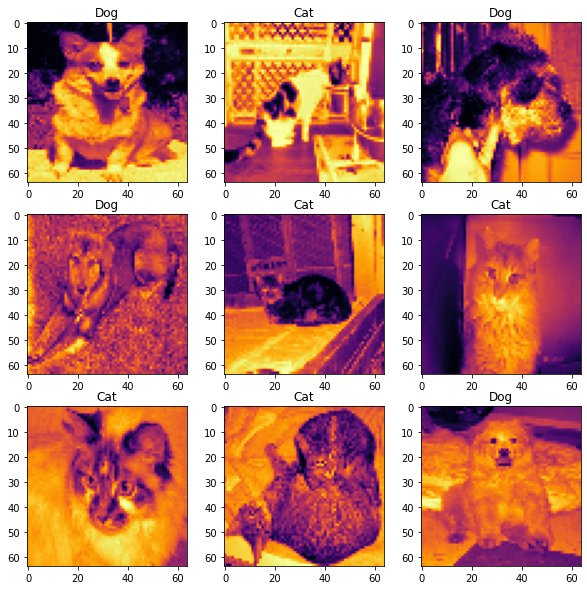

In [5]:
fig, ax = plt.subplots(3, 3, figsize=(10, 10))

for n in range(3):
    for m in range(3):
        ax[n, m].imshow(dataset[n*3+m][0][0]).set_cmap('inferno')
        if dataset[n*3+m][1] == 0: title = 'Cat'
        else: title = 'Dog'
        ax[n, m].set_title(title)

plt.show()

### Training and validation set (30%)

In [6]:
split_valid = 0.3
n_valid = int(split_valid*len(X))

dataset_train = dataset[0:len(X)-n_valid]
dataset_valid = dataset[len(X)-n_valid:len(X)]

count_cat = 0
count_dog = 0
for n in range(len(dataset_train)):
    if dataset_train[n][1] == 0:
        count_cat = count_cat+1
    else:
        count_dog = count_dog+1
print('There are {} cats and {} dogs in training set.'.format(count_cat, count_dog))

count_cat = 0
count_dog = 0
for n in range(len(dataset_valid)):
    if dataset_valid[n][1] == 0:
        count_cat = count_cat+1
    else:
        count_dog = count_dog+1
print('There are {} cats and {} dogs in validation set.'.format(count_cat, count_dog))

There are 8761 cats and 8739 dogs in training set.
There are 3739 cats and 3761 dogs in validation set.


In [7]:
batch_size = 1024
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=False, num_workers=1)
valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=False, num_workers=1)

In [8]:
class CNN_Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.relu1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d(p=0.5)
        self.maxpool2 = nn.MaxPool2d(2)
        self.relu2 = nn.ReLU()
        
        self.conv3 = nn.Conv2d(20, 10, kernel_size=5)
        self.relu3 = nn.ReLU()
        
        self.conv4 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv4_drop = nn.Dropout2d(p=0.5)
        self.maxpool4 = nn.MaxPool2d(2)
        self.relu4 = nn.ReLU()
        
        self.fc1 = nn.Linear(2000, 50)
        self.fc2 = nn.Linear(50, 2)

    def forward(self, x):       
        x = self.conv1(x)                        
        x = self.relu1(x)                        
        
        x = self.conv2(x)               
        x = self.conv2_drop(x)
        x = self.maxpool2(x)
        x = self.relu2(x)
        
        x = self.conv3(x)                        
        x = self.relu3(x)                        
        
        x = self.conv4(x)               
        x = self.conv4_drop(x)
        x = self.maxpool4(x)
        x = self.relu4(x)
        
        x = x.view(-1, 2000)
        
        x = self.fc1(x)
        x = F.relu(x)
        x = F.dropout(x, training=True)
        
        x = self.fc2(x)
        return x

In [9]:
net = CNN_Model()

if cuda.is_available():
    net = net.cuda()

criterion = nn.CrossEntropyLoss()

learning_rate = 0.1
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9) 

In [10]:
net

CNN_Model(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu2): ReLU()
  (conv3): Conv2d(20, 10, kernel_size=(5, 5), stride=(1, 1))
  (relu3): ReLU()
  (conv4): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv4_drop): Dropout2d(p=0.5, inplace=False)
  (maxpool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu4): ReLU()
  (fc1): Linear(in_features=2000, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=2, bias=True)
)

In [11]:
num_epochs = 150

train_loss = []
valid_loss = []
train_accuracy = []
valid_accuracy = []

for epoch in range(num_epochs):
    iter_loss = 0.0
    correct = 0
    iterations = 0
    
    net.train()
    
    for i, (items, classes) in enumerate(train_loader):
        items = Variable(items)
        classes = Variable(classes)
        
        if cuda.is_available():
            items = items.cuda()
            classes = classes.cuda()
        
        optimizer.zero_grad()
        outputs = net(items)
        loss = criterion(outputs, classes)
        iter_loss += loss.item()
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == classes.data).sum()
        iterations += 1

    train_loss.append(iter_loss/iterations)
    
    train_accuracy.append((100 * correct.float() / len(train_loader.dataset)))
    
    loss = 0.0
    correct = 0
    iterations = 0

    net.eval()
    
    for i, (items, classes) in enumerate(valid_loader):
        items = Variable(items)
        classes = Variable(classes)
        
        if cuda.is_available():
            items = items.cuda()
            classes = classes.cuda()
        
        outputs = net(items)
        loss += criterion(outputs, classes).item()
        
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == classes.data).sum()
        
        iterations += 1

    valid_loss.append(loss/iterations)
    correct_scalar = np.array([correct.clone().cpu()])[0]
    valid_accuracy.append(correct_scalar / len(valid_loader.dataset) * 100.0)

    print ('Epoch %d/%d, Tr Loss: %.4f, Tr Acc: %.4f, Val Loss: %.4f, Val Acc: %.4f'
           %(epoch+1, num_epochs, train_loss[-1], train_accuracy[-1], valid_loss[-1], valid_accuracy[-1]))

Epoch 1/150, Tr Loss: 0.6938, Tr Acc: 50.3143, Val Loss: 0.6926, Val Acc: 52.9600
Epoch 2/150, Tr Loss: 0.6920, Tr Acc: 52.4857, Val Loss: 0.6883, Val Acc: 55.3467
Epoch 3/150, Tr Loss: 0.6845, Tr Acc: 55.2514, Val Loss: 0.6833, Val Acc: 54.8133
Epoch 4/150, Tr Loss: 0.6834, Tr Acc: 55.8743, Val Loss: 0.6687, Val Acc: 60.2533
Epoch 5/150, Tr Loss: 0.6707, Tr Acc: 59.0114, Val Loss: 0.6624, Val Acc: 61.2800
Epoch 6/150, Tr Loss: 0.6679, Tr Acc: 59.7943, Val Loss: 0.6531, Val Acc: 62.6000
Epoch 7/150, Tr Loss: 0.6570, Tr Acc: 61.8343, Val Loss: 0.6436, Val Acc: 63.4000
Epoch 8/150, Tr Loss: 0.6468, Tr Acc: 63.2971, Val Loss: 0.6298, Val Acc: 65.8000
Epoch 9/150, Tr Loss: 0.6416, Tr Acc: 64.1543, Val Loss: 0.6229, Val Acc: 66.2400
Epoch 10/150, Tr Loss: 0.6324, Tr Acc: 65.3771, Val Loss: 0.6382, Val Acc: 62.9600
Epoch 11/150, Tr Loss: 0.6322, Tr Acc: 65.0914, Val Loss: 0.6157, Val Acc: 67.3067
Epoch 12/150, Tr Loss: 0.6225, Tr Acc: 66.3943, Val Loss: 0.6051, Val Acc: 68.5600
Epoch 13/150,

In [12]:
torch.save(net.state_dict(), 'model')

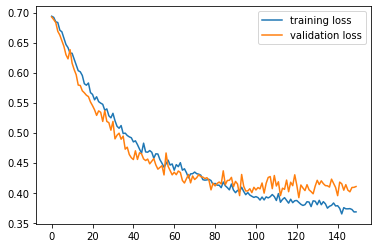

In [13]:
plt.plot(train_loss, label='training loss')
plt.plot(valid_loss, label='validation loss')
plt.legend()
plt.show()

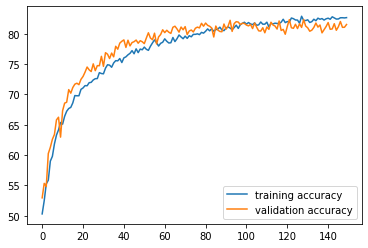

In [14]:
plt.plot(train_accuracy, label='training accuracy')
plt.plot(valid_accuracy, label='validation accuracy')
plt.legend()
plt.show()

### testing new images

In [15]:
name_test = os.listdir('test1')

arr = np.arange(len(name_test))
np.random.shuffle(arr)

X_test = np.zeros((9, 1, 64, 64), dtype='float32')

for n in range(9):
    img = cv2.imread('test1/'+name_test[arr[n]], cv2.IMREAD_GRAYSCALE)
    X_test[n, 0] = cv2.resize(img, (64, 64))
    
X_test = (X_test-mean)/std
X_test_tensor = torch.from_numpy(X_test)
X_test_tensor = Variable(X_test_tensor)

In [16]:
net.eval()

if cuda.is_available():
    net = net.cuda()
    X_test_tensor = X_test_tensor.cuda()
else:
    net = net.cpu()
    X_test_tensor = X_test_tensor.cpu()
    
output = net(X_test_tensor)
_, predicted = torch.max(output.data, 1)

### Results. Heading above the images are predicted results

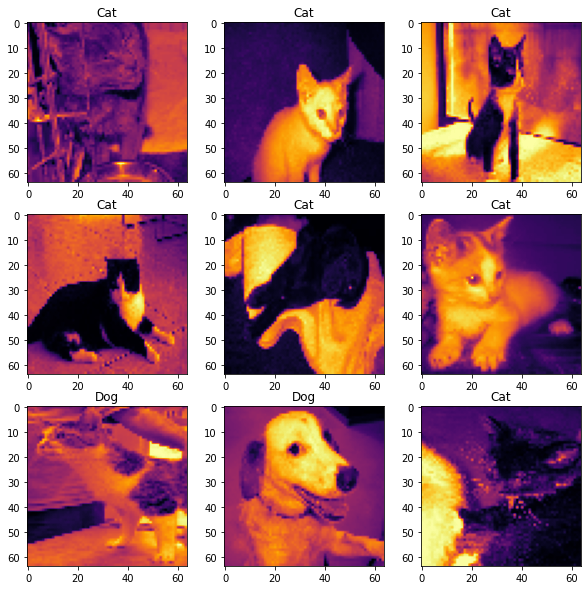

In [17]:
fig, ax = plt.subplots(3, 3, figsize=(10, 10))

for n in range(3):
    for m in range(3):
        ax[n, m].imshow(X_test[n*3+m][0]).set_cmap('inferno')
        if predicted[n*3+m].item() == 0: title = 'Cat'
        else: title = 'Dog'
        ax[n, m].set_title(title)

plt.show()